In [2]:
import requests
import json
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg
from tkinter import *
from datetime import datetime
from cassandra.cluster import Cluster
from cassandra.auth import PlainTextAuthProvider

# Function to retrieve data from Astra
def get_data_from_astra():
    try:
        # Load secrets from token file
        with open("DCBDMS_LAG-token.json") as f:
            secrets = json.load(f)
        CLIENT_ID = secrets["clientId"]
        CLIENT_SECRET = secrets["secret"]
        
        # Load Cassandra secure connect bundle
        cloud_config = {'secure_connect_bundle': 'secure-connect-dcbdms-lag.zip'}
        auth_provider = PlainTextAuthProvider(CLIENT_ID, CLIENT_SECRET)
        cluster = Cluster(cloud=cloud_config, auth_provider=auth_provider)
        session = cluster.connect()
        
        # Update keyspace and table name
        keyspace = 'dcbdms_keyspace'
        table_name = 'lagairdf'
        
        # Build and execute the query
        query = f"SELECT * FROM {keyspace}.{table_name}"
        rows = session.execute(query)
        
        # Convert rows to a list of dictionaries
        data = [row._asdict() for row in rows]
        
        # Convert list of dictionaries to a pandas DataFrame
        return pd.DataFrame(data)
        
    except Exception as e:
        print(f"Error retrieving data from Astra: {e}")
        return None
    finally:
        if 'session' in locals():
            session.shutdown()
        if 'cluster' in locals():
            cluster.shutdown()

# Attempt to get data from Astra
df = get_data_from_astra()

# If df is None, fallback activated
if df is None:
    print("Retrieving data from local host...")
    data_path = 'lagairdf.csv'
    df = pd.read_csv(data_path)
    df['startdate'] = pd.to_datetime(df['startdate'])
    df['enddate'] = pd.to_datetime(df['enddate'])


df = df.sort_values(by=['startdate'], ascending=False)

df.head()

Error retrieving data from Astra: [Errno 2] No such file or directory: 'secure-connect-dcbdms-lag.zip'
Retrieving data from local host...


,startdate,enddate,PM2.5,PM10,NO,NO2,Nox,NH3,SO2,CO,...,Temp,RH,WS,WD,SR,BP,VWS,Xylene,RF,AT
0,2023-12-03 23:00:00,2023-03-13 00:00:00,55.25,69.75,37.77,69.05,67.43,4.50,5.08,1.06,...,30.50,71.25,0.30,NaN,10.0,NaN,-0.2,0.88,0.0,21.50
1,2023-12-03 22:00:00,2023-12-03 23:00:00,57.25,82.50,39.15,71.95,70.07,5.12,5.85,1.24,...,30.52,74.75,0.30,NaN,10.0,NaN,-0.2,1.12,0.0,21.50
2,2023-12-03 21:00:00,2023-12-03 22:00:00,50.50,83.25,38.48,72.28,69.70,8.73,5.73,1.40,...,30.52,79.50,0.33,92.50,10.0,NaN,-0.2,1.23,0.0,21.68
3,2023-12-03 20:00:00,2023-12-03 21:00:00,45.00,76.75,19.72,61.65,48.83,6.33,5.00,1.27,...,30.52,77.25,0.73,128.75,10.0,NaN,-0.2,0.85,0.0,22.23
4,2023-12-03 19:00:00,2023-12-03 20:00:00,36.50,62.25,16.62,57.25,43.95,6.55,4.72,1.15,...,30.55,73.50,0.77,99.00,10.0,NaN,-0.2,0.75,0.0,22.70


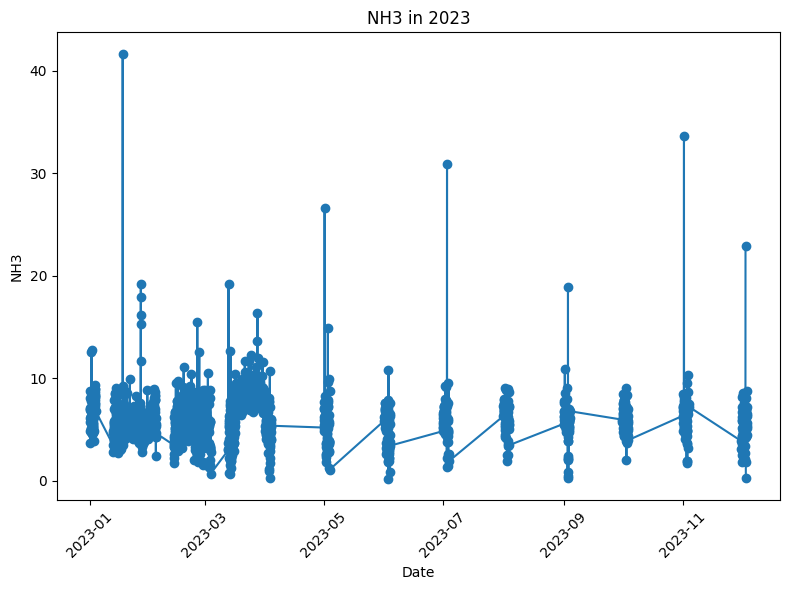

In [3]:
# GUI Creation
root = Tk()
root.title('LAGOS AIR QUALITY MONITORING SYSTEM')


# Updating Plot Function

def update_plot():
    selected_year = int(year_var.get())
    selected_attribute = attribute_var.get()
    selected_plot_type = plot_type_var.get()
    
    df_selected = df[df['startdate'].dt.year == selected_year]
    
    plt.clf()  
    
    if selected_plot_type == "Time Series":
        plt.plot(df_selected['startdate'], df_selected[selected_attribute], marker='o')
        plt.xlabel('Date')
        plt.ylabel(selected_attribute)
        plt.title(f'{selected_attribute} in {selected_year}')
        plt.xticks(rotation=45)
    
    elif selected_plot_type == "Scatter Plot":
        plt.scatter(df_selected[selected_attribute], df_selected['startdate'], marker='o', color='blue')
        plt.ylabel('Date')
        plt.xlabel(selected_attribute)
        plt.title(f'Scatter Plot of {selected_attribute} for {selected_year}')
    
    elif selected_plot_type == "Box Plot":
        df_selected.boxplot(column=selected_attribute)
        plt.title(f'Box Plot of {selected_attribute} for {selected_year}')
    
    plt.tight_layout()

    # Update Summary Statistics 
    stats_table = df_selected[selected_attribute].describe()
    stats_label.config(text=stats_table)

    plot_canvas.draw()  


# Year selection
year_label = Label(root, text='Select Year:')
year_label.pack()

year_var = StringVar()
year_var.set("2023")  

year_options = [str(year) for year in df['startdate'].dt.year.unique()]
year_menu = OptionMenu(root, year_var, *year_options)
year_menu.pack()

# Attribute selection
attribute_label = Label(root, text='Select Attribute:')
attribute_label.pack()

attribute_var = StringVar()
attribute_var.set(df.columns[2])  

attribute_options = list(df.columns[2:])
attribute_menu = OptionMenu(root, attribute_var, *attribute_options)
attribute_menu.pack()

# Plot type selection
plot_type_label = Label(root, text='Select Plot Type:')
plot_type_label.pack()

plot_type_var = StringVar()
plot_type_var.set("Time Series")  

plot_type_options = ["Time Series", "Scatter Plot", "Box Plot"]
plot_type_menu = OptionMenu(root, plot_type_var, *plot_type_options)
plot_type_menu.pack()


button_plot_frame = Frame(root)
button_plot_frame.pack(padx=10, pady=10)

plot_button = Button(button_plot_frame, text="Plot Data", command=update_plot, bg='green', fg='white', font=('Helvetica', 12, 'bold'))
plot_button.pack(side=LEFT, padx=10)

# Plot canvas
plot_canvas = FigureCanvasTkAgg(plt.figure(figsize=(8, 6)), master=root)
plot_canvas.get_tk_widget().pack(side=LEFT, padx=10, pady=10)


stats_label = Label(root, text='', font=('Helvetica', 12, 'bold'))
stats_label.pack(side=LEFT, padx=10, pady=10)

# Run the GUI
root.mainloop()